### Dataset
In this homework, we will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

Here's a wget-able link:

`wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv`
The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column 'JAMB_Score').

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import export_text

import xgboost as xgb

In [3]:
file = "https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv"

In [4]:
df = pd.read_csv(file)
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


### Preparing the dataset
First, let's make the names lowercase:

`df.columns = df.columns.str.lower().str.replace(' ', '_')`

Preparation:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the `train_test_split` function and set the random_state parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df.drop(['student_id'], axis=1)
df.fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   jamb_score                    5000 non-null   int64  
 1   study_hours_per_week          5000 non-null   int64  
 2   attendance_rate               5000 non-null   int64  
 3   teacher_quality               5000 non-null   int64  
 4   distance_to_school            5000 non-null   float64
 5   school_type                   5000 non-null   object 
 6   school_location               5000 non-null   object 
 7   extra_tutorials               5000 non-null   object 
 8   access_to_learning_materials  5000 non-null   object 
 9   parent_involvement            5000 non-null   object 
 10  it_knowledge                  5000 non-null   object 
 11  age                           5000 non-null   int64  
 12  gender                        5000 non-null   object 
 13  soc

In [6]:
df_fulltrain, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_fulltrain, test_size=0.25, random_state=1)
print(df_train.shape, df_val.shape, df_test.shape)

(3000, 16) (1000, 16) (1000, 16)


In [7]:
y_train = df_train['jamb_score'].values
df_train = df_train.drop('jamb_score', axis=1)

y_val = df_val['jamb_score'].values
df_val = df_val.drop('jamb_score', axis=1)

y_test = df_test['jamb_score'].values
df_test = df_test.drop('jamb_score', axis=1)

In [8]:
dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
X_test = dv.transform(df_test.to_dict(orient='records'))

### Question 1
Let's train a decision tree regressor to predict the jamb_score variable.

Train a model with `max_depth=1`.

Which feature is used for splitting the data?

* study_hours_per_week
* attendance_rate
* teacher_quality
* distance_to_school


In [9]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



### Question 2
Train a random forest regressor with these parameters:

`n_estimators=10`
`random_state=1`
`n_jobs=-1` (optional - to make training faster)

What's the RMSE of this model on the validation data?

* 22.13
* 42.13
* 62.13
* 82.12

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
round(root_mean_squared_error(y_val, y_pred), 2)

42.14

### Question 3
Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to 1.
* Evaluate the model on the validation dataset.

After which value of `n_estimators` does RMSE stop improving? Consider 3 decimal places for calculating the answer.

* 10
* 25
* 80
* 200

In [12]:
rmse = {}
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse[n] = round(root_mean_squared_error(y_val, y_pred),3)

In [13]:
df_rmse = pd.DataFrame(rmse.items(), columns=['n_estimators', 'rmse'])
df_rmse.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
n_estimators,10.000,20.000,30.000,40.000,50.000,60.000,70.000,80.000,90.000,100.000,110.000,120.000,130.000,140.000,150.000,160.000,170.000,180.000,190.000,200.000
rmse,42.137,41.461,41.106,40.917,40.852,40.784,40.677,40.539,40.504,40.517,40.593,40.625,40.651,40.595,40.597,40.604,40.628,40.641,40.631,40.601


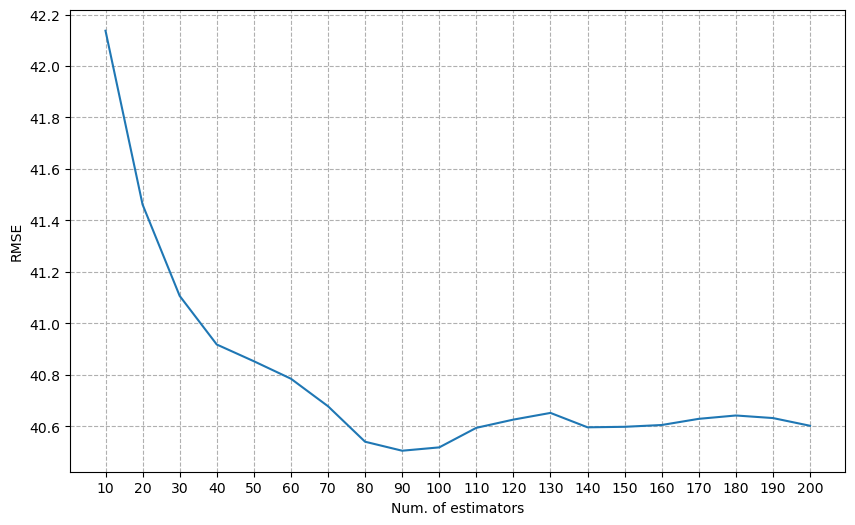

In [14]:
plt.figure(figsize=(10,6))
plt.plot(df_rmse['n_estimators'], df_rmse['rmse'])
plt.grid(linestyle="--")
plt.xlabel("Num. of estimators")
plt.ylabel("RMSE")
plt.xticks(range(10,201,10))
plt.show()

### Question 4
Let's select the best `max_depth`:

Try different values of `max_depth`: [10, 15, 20, 25]

For each of these values,

* try different values of `n_estimators` from 10 till 200 (with step 10)
* calculate the mean RMSE.
* Fix the random seed: `random_state=1`

What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [15]:
rmse = {}
for d in [10, 15, 20, 25]:
    total_rmse = []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        total_rmse.append(root_mean_squared_error(y_val, y_pred))
    
    rmse[d] = sum(total_rmse)/len(total_rmse)

In [16]:
df_rmse = pd.DataFrame(rmse.items(), columns=['max_depth', 'mean_rmse'])
df_rmse.sort_values(by=['mean_rmse'], ascending=True)

,max_depth,mean_rmse
0,10,40.392498
1,15,40.735282
2,20,40.739734
3,25,40.787866


### Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
`n_estimators=10`,
`max_depth=20`,
`random_state=1`,
`n_jobs=-1` (optional)

Get the feature importance information from this model

What's the most important feature (among these 4)?

* study_hours_per_week
* attendance_rate
* distance_to_school
* teacher_quality

In [17]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [18]:
rf_features = dict(zip(dv.get_feature_names_out(), rf.feature_importances_))
sorted(rf_features.items(), key=lambda x:x[1], reverse=True)[0]

('study_hours_per_week', 0.24835361199396533)

### Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:
```python
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```
Now change `eta` from `0.3` to `0.1`.

Which `eta` leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [19]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [20]:
def eta_tune_and_eval(dtrain, dval, y_val, eta):
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }
    
    model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    y_pred = model.predict(dval)
    return root_mean_squared_error(y_val, y_pred)


In [21]:
rmse = {eta: eta_tune_and_eval(dtrain, dval, y_val, eta) for eta in [0.3, 0.1]}
sorted(rmse.items(), key=lambda x: x[1])

[(0.1, 41.05034017683498), (0.3, 43.418817345871766)]